# Chinese handwritten numbers classification

In [39]:
import numpy as np
import pandas as pd
import pathlib
import os

import tensorflow as tf
from tensorflow import keras

In [3]:
CLASSES = {
    0: '0',
    1: '1',
    2: '2',
    3: '3',
    4: '4',
    5: '5',
    6: '6',
    7: '7',
    8: '8',
    9: '9',
    10: '10',
    11: '100',
    12: '1000',
    13: '10000',
    14: '100000000'
}

**Global variables and dataset initialization**

In [34]:
DATA_DIR = pathlib.Path('../input/chinese-mnist/data/data')
BATCH_SIZE = 32
IMG_HEIGHT = 64
IMG_WIDTH = 64
IMAGE_COUNT = len(list(DATA_DIR.glob('*.jpg')))
AUTOTUNE = tf.data.AUTOTUNE

main_ds = tf.data.Dataset.list_files(str(DATA_DIR/'*'), shuffle=False)
main_ds = main_ds.shuffle(IMAGE_COUNT, reshuffle_each_iteration=False)

In [35]:
def transform_data(file_path):
    # get label
    label_part = tf.strings.split(tf.strings.split(tf.strings.split(file_path, os.path.sep)[-1], '_')[-1], '.')[0]
    label = tf.one_hot((tf.strings.to_number(label_part, tf.int32) -1) , 15)
    # read image
    img = tf.io.read_file(file_path)
    # decode and resize image
    img = tf.image.decode_jpeg(img, channels=1)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    return img, label

**Data preparation**

In [36]:
test_size = 50
val_size = int(IMAGE_COUNT * 0.2)

train_ds = main_ds.skip(val_size + test_size)
val_ds = main_ds.take(val_size)
test_ds = main_ds.take(test_size)

train_ds = train_ds.map(transform_data, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(transform_data, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(transform_data, num_parallel_calls=AUTOTUNE)

train_ds = train_ds.batch(BATCH_SIZE).prefetch(1)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(1)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(1)

# Model building 

In [37]:
def build_model():
    model = keras.models.Sequential([
        keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
        keras.layers.experimental.preprocessing.Rescaling(scale=1./255.),
        keras.layers.Conv2D(filters=33, kernel_size=(3, 3), strides=1, activation="relu"),
        keras.layers.Conv2D(filters=33, kernel_size=(3, 3), strides=1, activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2), strides=2),
        keras.layers.Conv2D(filters=65, kernel_size=(5, 5), strides=1, activation="relu"),
        keras.layers.Conv2D(filters=65, kernel_size=(5, 5), strides=1, activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2), strides=2),
        keras.layers.Conv2D(filters=133, kernel_size=(5, 5), activation="relu"),
        keras.layers.Conv2D(filters=133, kernel_size=(5, 5), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2)),
        keras.layers.Flatten(),
        keras.layers.Dense(units=31, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(units=15, activation="softmax"),
    ])

    model.compile(
        optimizer='adam',
        loss="categorical_crossentropy",
        metrics=['accuracy']
    )
    return model

Epoch 1/15
374/374 [==============================] - 9s 23ms/step - loss: 1.7963 - accuracy: 0.4786 - val_loss: 0.2913 - val_accuracy: 0.9680
Epoch 2/15
374/374 [==============================] - 8s 21ms/step - loss: 0.3309 - accuracy: 0.9534 - val_loss: 0.0626 - val_accuracy: 0.9900
Epoch 3/15
374/374 [==============================] - 8s 21ms/step - loss: 0.1157 - accuracy: 0.9851 - val_loss: 0.0300 - val_accuracy: 0.9933
Epoch 4/15
374/374 [==============================] - 7s 20ms/step - loss: 0.0624 - accuracy: 0.9914 - val_loss: 0.0528 - val_accuracy: 0.9853
Epoch 5/15
374/374 [==============================] - 8s 21ms/step - loss: 0.0542 - accuracy: 0.9900 - val_loss: 0.0222 - val_accuracy: 0.9953
Epoch 6/15
374/374 [==============================] - 8s 20ms/step - loss: 0.0388 - accuracy: 0.9931 - val_loss: 0.0274 - val_accuracy: 0.9957
Epoch 7/15
374/374 [==============================] - 8s 21ms/step - loss: 0.0263 - accuracy: 0.9960 - val_loss: 0.0328 - val_accuracy: 0.9907

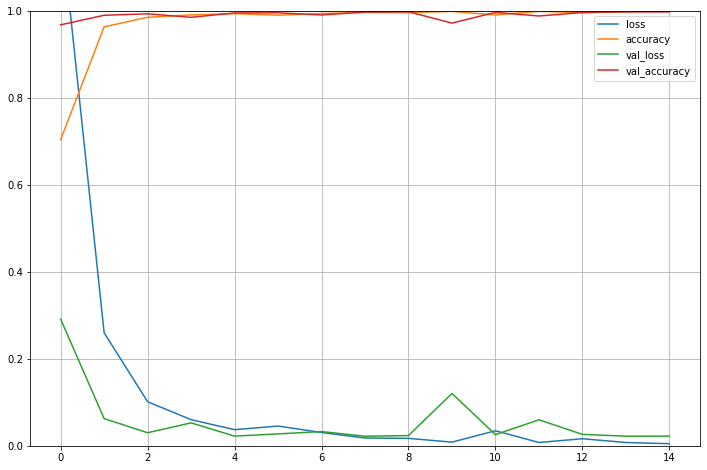

In [38]:
model = build_model()
checkpoint_cb = keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=BATCH_SIZE,
    epochs=15,
    callbacks=[checkpoint_cb]
)

pd.DataFrame(history.history).plot(figsize=(12, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [40]:
saved_model = keras.models.load_model('./best_model.h5')
saved_model.evaluate(test_ds)

2/2 [==============================] - 0s 45ms/step - loss: 0.0018 - accuracy: 1.0000


[0.0017894550692290068, 1.0]